# Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
from shapely.geometry import Point
from shapely.geometry import LineString
import seaborn as sns

# Defining paths

In [2]:
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_02_IL'
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_01_CA1'
# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211206/mouse_02_IL'
cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211206/mouse_01_CA1'

path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')

# Parameters

In [3]:
n_palette = 20

# Loading files

In [4]:
path_pickle = os.path.join(cur_dir, 'pickle')
with open(os.path.join(path_pickle, 'meta_spikes.pck'), 'rb') as f:
    meta_spikes = pickle.load(f)
with open(os.path.join(path_pickle, 'df_dlc.pck'), 'rb') as f:
    df_dlc = pickle.load(f)
with open(os.path.join(path_pickle, 'mat_spikes.pck'), 'rb') as f:
    mat_spikes = pickle.load(f)
with open(os.path.join(path_pickle, 'df_frames.pck'), 'rb') as f:
    df_frames = pickle.load(f)
with open(os.path.join(path_pickle, 'dict_meta.pck'), 'rb') as f:
    dict_meta = pickle.load(f)

# Adding session type data

In [5]:
df_dlc['environment'] = ''
for k,d in dict_meta['dict_env'].items():
    val_sessions = [df_frames.loc[idx, 'session'] for idx in d]    
    sub_df = df_dlc.query('session in @val_sessions')
    df_dlc.loc[sub_df.index, 'environment'] = k

# Finding maze limits

## Function

In [6]:
def plotTrajectoryEnv(k, color_frames = False):

    selected_sessions = dict_meta['dict_env'][k]
    
    lname = list()
    for idx in selected_sessions:
        lname.append(df_frames.loc[idx, 'session'])

    for i,r in df_frames.iterrows():
        if r['session'] not in lname:
            continue

        cur_session = r['session']
        sub_spikes = meta_spikes.query('session == @cur_session')

        if not color_frames:
            plt.plot(sub_spikes['x'], sub_spikes['y'], c = 'darkgray', alpha = 1, linewidth = 2, zorder = -1)   
        else:
            df_dlc_axis = df_dlc[['closest_arm', 'projection', 'environment']]
            sub_spikes = sub_spikes.join(df_dlc_axis, on = 'behavioral_frame')
            pal_name = {'middle': 'Greens',
                        'left': 'Reds',
                        'right': 'Blues'}
            
            for i,arm in enumerate(['middle', 'left', 'right']):
                cur_pal = np.array(sns.color_palette(pal_name[arm], n_palette, as_cmap=False))
                sub_spikes_region = sub_spikes.query('(closest_arm == @arm) & (environment == @k)')
                # plt.scatter(sub_spikes_region['x'], sub_spikes_region['y'], c = col_vect[i])
                bin_code = np.digitize(sub_spikes_region['projection'], np.linspace(0,1.001,num=n_palette+1)) 
                plt.scatter(sub_spikes_region['x'], sub_spikes_region['y'], c = cur_pal[bin_code-1])
            
    c = coords[k]
    plt.plot([c['x_c'], c['x_m']], [c['y_c'], c['y_m']], c = 'g', marker = 'o')
    plt.plot([c['x_c'], c['x_l']], [c['y_c'], c['y_l']], c = 'r', marker = 'o')
    plt.plot([c['x_c'], c['x_r']], [c['y_c'], c['y_r']], c = 'b', marker = 'o')
    plt.gca().set_aspect('equal')

## Coordinates dots

### t_maze

In [7]:
# with open(os.path.join(path_pickle, '../pickle_backup/dict_meta.pck'), 'rb') as f:
#     dict_meta = pickle.load(f)
# with open(os.path.join(path_pickle, '../pickle_backup/reference_points.pck'), 'rb') as f:
#     coords = pickle.load(f)

In [8]:
with open(os.path.join(path_pickle, 'meta_spikes.pck'), 'rb') as f:
    meta_spikes = pickle.load(f)
    
# dict_meta['offset'] = {
#     'WIN_20211206_18_22_29_Pro': {
#         'x': -10,
#         'y': +5
#     }
# }
#     'WIN_20211204_15_28_13_Pro': {
#         'x': -10,
#         'y': +0
#     }
# }

if 'offset' in dict_meta.keys():
    for k,d in dict_meta['offset'].items():
        sub_meta = meta_spikes.query('session == @k')
        print(sub_meta.index)
        meta_spikes.loc[sub_meta.index, 'x'] += d['x']
        meta_spikes.loc[sub_meta.index, 'y'] += d['y']


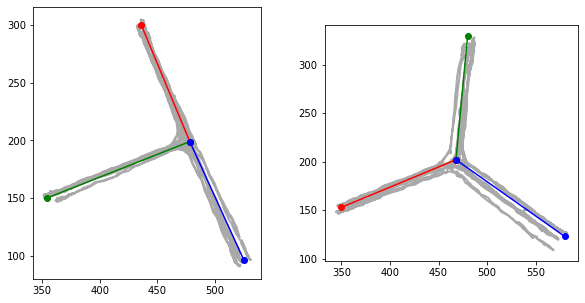

In [9]:
coords = dict()
coords['y_maze'] = {
    'x_c': 468,
    'y_c': 202,
    'x_m': 480,
    'y_m': 330,
    'x_l': 350,
    'y_l': 153,
    'x_r': 580,
    'y_r': 123   
}
coords['t_maze'] = {
    'x_c': 478,
    'y_c': 199,
    'x_m': 354,
    'y_m': 150,
    'x_l': 436,
    'y_l': 300,
    'x_r': 525,
    'y_r': 96
}
    
plt.figure(figsize = (10,5))
plt.subplot(121)
plotTrajectoryEnv('t_maze', False)
plt.subplot(122)
plotTrajectoryEnv('y_maze', False)

### y_maze

## Computing distance to line

In [10]:
df_dlc['closest_arm'] = ''
for env in ['t_maze', 'y_maze']:
    c = coords[env]
    sub_df = df_dlc.query('environment == @env')
    dist_m = [LineString([(c['x_c'], c['y_c']), (c['x_m'], c['y_m'])]).distance(Point(r['xc'], r['yc'])) for _,r in sub_df.iterrows()]
    dist_l = [LineString([(c['x_c'], c['y_c']), (c['x_l'], c['y_l'])]).distance(Point(r['xc'], r['yc'])) for _,r in sub_df.iterrows()]
    dist_r = [LineString([(c['x_c'], c['y_c']), (c['x_r'], c['y_r'])]).distance(Point(r['xc'], r['yc'])) for _,r in sub_df.iterrows()]
    mat_distances = np.array([dist_m, dist_l, dist_r])
    df_dlc.loc[sub_df.index, 'closest_arm'] = np.array(['middle', 'left', 'right'])[np.argmin(mat_distances, axis = 0)]

## Projection to the closest line

In [11]:
df_dlc['projection'] = 0

for env in ['t_maze', 'y_maze']:
    c = coords[env]
    for arm in ['middle', 'left', 'right']:
        if arm == 'middle':
            x = c['x_m']
            y = c['y_m']
        elif arm == 'left':
            x = c['x_l']
            y = c['y_l']
        elif arm == 'right':
            x = c['x_r']
            y = c['y_r']
        sub_df = df_dlc.query('(closest_arm == @arm) & (environment == @env)')
        proj = [LineString([(c['x_c'], c['y_c']), (x, y)]).project(Point(r['xc'], r['yc']), normalized=True) for _,r in sub_df.iterrows()]
        df_dlc.loc[sub_df.index, 'projection'] = proj

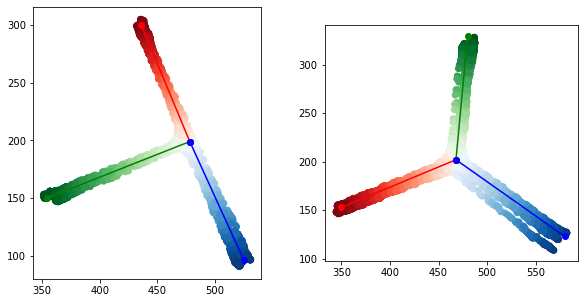

In [12]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plotTrajectoryEnv('t_maze', True)
plt.subplot(122)
plotTrajectoryEnv('y_maze', True)

# Saving data 

In [13]:
with open(os.path.join(cur_dir, 'pickle', 'df_dlc_projections.pck'), 'wb') as f:
    pickle.dump(df_dlc, f)
if os.path.exists(os.path.join(cur_dir, 'pickle', 'reference_points.pck')):
    sys.exit('There is already a reference point file, are you sure you want to delete?')
with open(os.path.join(cur_dir, 'pickle', 'reference_points.pck'), 'wb') as f:
    pickle.dump(coords, f)
with open(os.path.join(cur_dir, 'pickle', 'dict_meta.pck'), 'wb') as f:
    pickle.dump(dict_meta, f)